In [42]:
# Install required packages
try:
    import seqeval
except ImportError:
    print("Installing seqeval...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'seqeval'])
    import seqeval

In [43]:
import json
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    DistilBertForTokenClassification,
    GPT2Tokenizer,
    GPT2ForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from seqeval.metrics import classification_report as ner_report, f1_score as ner_f1
import warnings
warnings.filterwarnings('ignore')

In [4]:
CONFIG = {
    # General
    'max_length': 128,
    'batch_size': 16,
    'train_split': 0.75,
    'random_seed': 42,
    'save_dir': '/kaggle/working/',
    
    # Intent Classification - DistilBERT
    'intent_distilbert': {
        'model_name': 'distilbert-base-multilingual-cased',
        'learning_rate': 5e-5,
        'epochs': 25,
        'warmup_steps': 50,
        'weight_decay': 0.1,
        'dropout': 0.3,
        'early_stopping_patience': 5
    },
    
    # Intent Classification - GPT-2
    'intent_gpt2': {
        'model_name': 'gpt2',
        'learning_rate': 3e-5,
        'epochs': 25,
        'warmup_steps': 50,
        'weight_decay': 0.1,
        'dropout': 0.3,
        'early_stopping_patience': 5
    },
    
    # Named Entity Recognition
    'ner': {
        'model_name': 'distilbert-base-multilingual-cased',
        'learning_rate': 1e-5,
        'epochs': 30,
        'warmup_steps': 100,
        'weight_decay': 0.01,
        'dropout': 0.3
    }
}

# Intent Labels
INTENT_LABELS = [
    'bus_schedule',
    'waste_collection',
    'weather',
    'admin_procedure',
    'contact_emergency',
    'find_administration'
]

# Entity Labels (BIO format for NER)
ENTITY_LABELS = [
    'O',  # Outside any entity
    'B-bus_line', 'I-bus_line',
    'B-district', 'I-district',
    'B-date', 'I-date',
    'B-document_type', 'I-document_type',
    'B-emergency_type', 'I-emergency_type',
    'B-office_name', 'I-office_name'
]

In [5]:
# Create mappings
intent2id = {label: idx for idx, label in enumerate(INTENT_LABELS)}
id2intent = {idx: label for label, idx in intent2id.items()}
label2id = {label: idx for idx, label in enumerate(ENTITY_LABELS)}
id2label = {idx: label for label, idx in label2id.items()}

In [6]:
# Set random seeds
torch.manual_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['random_seed'])

print("Configuration loaded successfully!")
print(f"Intent labels: {len(INTENT_LABELS)}")
print(f"Entity labels: {len(ENTITY_LABELS)}")

Configuration loaded successfully!
Intent labels: 6
Entity labels: 13


In [7]:
def load_json_data(file_path):
    """Load data from JSON file"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    print(f"✓ Loaded {len(data)} examples from {file_path}")
    return data

In [8]:
def augment_data(data):
    """Simple data augmentation for better generalization"""
    augmented = []
    
    replacements = {
        'bus_schedule': [
            ('What time does', 'When does'),
            ('go from', 'leave'),
            ('What time', 'When'),
            ('arrive at', 'get to'),
        ],
        'waste_collection': [
            ('waste be collected', 'garbage pickup'),
            ('waste be collected', 'trash collection'),
            ('When will', 'What time is'),
            ('collected', 'picked up'),
        ],
        'weather': [
            ('What is the weather', "What's the weather like"),
            ('What is the weather', 'How is the weather'),
            ('Will it rain', 'Is it going to rain'),
        ],
        'admin_procedure': [
            ('How do I get', 'Where can I get'),
            ('How do I apply', 'Where do I apply'),
        ],
        'contact_emergency': [
            ('What is the number', 'How do I contact'),
            ('emergency number', 'contact number'),
        ]
    }
    
    for item in data:
        augmented.append(item)  # Keep original
        
        # Add 1-2 augmented versions per example
        if item['intent'] in replacements:
            for old, new in replacements[item['intent']][:2]:
                if old in item['text']:
                    new_item = item.copy()
                    new_item['text'] = item['text'].replace(old, new)
                    new_item['entities'] = item.get('entities', []).copy()
                    augmented.append(new_item)
    
    return augmented

In [9]:
class IntentDataset(Dataset):
    """Dataset for Intent Classification"""
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['text']
        intent = item['intent']

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(intent2id[intent], dtype=torch.long)
        }

In [10]:
class NERDataset(Dataset):
    """Dataset for Named Entity Recognition"""
    def __init__(self, data, tokenizer, max_length, label2id):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label2id = label2id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['text']
        entities = item.get('entities', [])

        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        # Create labels array (all O by default)
        labels = ['O'] * self.max_length
        offset_mapping = encoding['offset_mapping'].squeeze(0).tolist()

        # Map entities to tokens using BIO tagging
        for entity in entities:
            entity_start = entity['start']
            entity_end = entity['end']
            entity_label = entity['label']

            first_token = True
            for token_idx, (token_start, token_end) in enumerate(offset_mapping):
                # Skip special tokens and padding
                if token_start == 0 and token_end == 0:
                    continue

                # Check if token overlaps with entity
                if token_start < entity_end and token_end > entity_start:
                    if first_token:
                        labels[token_idx] = f'B-{entity_label}'
                        first_token = False
                    else:
                        labels[token_idx] = f'I-{entity_label}'

        # Convert labels to ids
        label_ids = [self.label2id[label] for label in labels]

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label_ids, dtype=torch.long)
        }

In [11]:
def train_epoch_intent(model, dataloader, optimizer, scheduler, device):
    """Training function for intent classification"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training Intent")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        predictions = torch.argmax(logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({'loss': loss.item(), 'acc': correct/total})

    return total_loss / len(dataloader), correct / total

In [12]:
def evaluate_intent(model, dataloader, device):
    """Evaluation function for intent classification"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Intent"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))

    return total_loss / len(dataloader), accuracy, all_predictions, all_labels

In [13]:
def train_epoch_ner(model, dataloader, optimizer, scheduler, device):
    """Training function for NER"""
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Training NER")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(dataloader)

In [14]:
def evaluate_ner(model, dataloader, device, id2label):
    """Evaluation function for NER"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating NER"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)

            # Convert to label strings for seqeval
            for pred_seq, label_seq, mask in zip(predictions, labels, attention_mask):
                pred_labels = []
                true_labels = []

                for p, l, m in zip(pred_seq, label_seq, mask):
                    if m.item() == 1 and l.item() != -100:
                        pred_labels.append(id2label[p.item()])
                        true_labels.append(id2label[l.item()])

                if pred_labels:
                    all_predictions.append(pred_labels)
                    all_labels.append(true_labels)

    # Calculate F1 score using seqeval
    f1 = ner_f1(all_labels, all_predictions)

    return total_loss / len(dataloader), f1, all_predictions, all_labels

In [15]:
def plot_confusion_matrix(y_true, y_pred, labels, title, filename):
    """Plot and save confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    print(f"✓ {title} saved to {filename}")

In [16]:
def plot_training_history(history, title, filename):
    """Plot and save training history"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss plot
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss over Epochs')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Metric plot (accuracy or F1)
    metric_name = 'Accuracy' if 'val_acc' in history else 'F1 Score'
    metric_key = 'val_acc' if 'val_acc' in history else 'val_f1'
    train_metric_key = 'train_acc' if 'train_acc' in history else None
    
    if train_metric_key and train_metric_key in history:
        axes[1].plot(history[train_metric_key], label=f'Train {metric_name}', marker='o')
    axes[1].plot(history[metric_key], label=f'Val {metric_name}', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel(metric_name)
    axes[1].set_title(f'{metric_name} over Epochs')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    print(f"✓ {title} saved to {filename}")

In [17]:
def train_intent_classifier(model_type='distilbert', data_path='dataset_complete.json'):
    """
    Train intent classifier (DistilBERT or GPT-2)
    
    Args:
        model_type: 'distilbert' or 'gpt2'
        data_path: path to dataset
    """
    print("\n" + "="*80)
    print(f"TRAINING INTENT CLASSIFIER - {model_type.upper()}")
    print("="*80)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load and prepare data
    data = load_json_data(data_path)
    data = augment_data(data)
    print(f"✓ After augmentation: {len(data)} examples")
    
    # Split data
    train_data, val_data = train_test_split(
        data,
        test_size=1-CONFIG['train_split'],
        random_state=CONFIG['random_seed'],
        stratify=[item['intent'] for item in data]
    )
    
    print(f"✓ Train: {len(train_data)} | Val: {len(val_data)}")
    
    # Initialize model and tokenizer
    config_key = f'intent_{model_type}'
    model_config = CONFIG[config_key]
    
    if model_type == 'distilbert':
        tokenizer = DistilBertTokenizerFast.from_pretrained(model_config['model_name'])
        model = DistilBertForSequenceClassification.from_pretrained(
            model_config['model_name'],
            num_labels=len(INTENT_LABELS),
            dropout=model_config['dropout'],
            attention_dropout=model_config['dropout']
        )
    elif model_type == 'gpt2':
        tokenizer = GPT2Tokenizer.from_pretrained(model_config['model_name'])
        tokenizer.pad_token = tokenizer.eos_token
        model = GPT2ForSequenceClassification.from_pretrained(
            model_config['model_name'],
            num_labels=len(INTENT_LABELS)
        )
        model.config.pad_token_id = tokenizer.eos_token_id
    
    model.to(device)
    
    # Create datasets and dataloaders
    train_dataset = IntentDataset(train_data, tokenizer, CONFIG['max_length'])
    val_dataset = IntentDataset(val_data, tokenizer, CONFIG['max_length'])
    
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'])
    
    # Optimizer and scheduler
    optimizer = AdamW(
        model.parameters(),
        lr=model_config['learning_rate'],
        weight_decay=model_config['weight_decay']
    )
    
    total_steps = len(train_loader) * model_config['epochs']
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=model_config['warmup_steps'],
        num_training_steps=total_steps
    )
    
    # Training loop
    best_val_acc = 0
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(model_config['epochs']):
        print(f"\nEpoch {epoch + 1}/{model_config['epochs']}")
        
        train_loss, train_acc = train_epoch_intent(model, train_loader, optimizer, scheduler, device)
        val_loss, val_acc, val_preds, val_labels = evaluate_intent(model, val_loader, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            save_path = CONFIG['save_dir'] + f'intent_{model_type}/'
            model.save_pretrained(save_path)
            tokenizer.save_pretrained(save_path)
            print(f"✓ Model saved with accuracy: {val_acc:.4f}")
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= model_config['early_stopping_patience']:
            print(f"\n⚠ Early stopping triggered after {epoch + 1} epochs")
            break
    
    # Final evaluation
    print("\n" + "="*80)
    print("FINAL EVALUATION")
    print("="*80)
    
    report = classification_report(val_labels, val_preds, target_names=INTENT_LABELS, digits=4)
    print("\nClassification Report:")
    print(report)
    
    # Save visualizations
    plot_confusion_matrix(
        val_labels, val_preds, INTENT_LABELS,
        f'Intent Classification - {model_type.upper()}',
        f'confusion_matrix_intent_{model_type}.png'
    )
    
    plot_training_history(
        history,
        f'Intent Classification Training - {model_type.upper()}',
        f'training_history_intent_{model_type}.png'
    )
    
    print(f"\n✓ Best validation accuracy: {best_val_acc:.4f}")
    print(f"✓ Model saved to: {CONFIG['save_dir']}intent_{model_type}/")
    
    return best_val_acc, history

In [18]:
def train_ner_model(data_path='dataset_complete.json'):
    """Train NER model using DistilBERT"""
    print("\n" + "="*80)
    print("TRAINING NER MODEL - DISTILBERT")
    print("="*80)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data
    data = load_json_data(data_path)
    
    # Split data
    train_data, val_data = train_test_split(
        data,
        test_size=1-CONFIG['train_split'],
        random_state=CONFIG['random_seed']
    )
    
    print(f"✓ Train: {len(train_data)} | Val: {len(val_data)}")
    
    # Initialize model and tokenizer
    ner_config = CONFIG['ner']
    tokenizer = DistilBertTokenizerFast.from_pretrained(ner_config['model_name'])
    model = DistilBertForTokenClassification.from_pretrained(
        ner_config['model_name'],
        num_labels=len(ENTITY_LABELS),
        id2label=id2label,
        label2id=label2id,
        dropout=ner_config['dropout'],
        attention_dropout=ner_config['dropout']
    )
    model.to(device)
    
    # Create datasets and dataloaders
    train_dataset = NERDataset(train_data, tokenizer, CONFIG['max_length'], label2id)
    val_dataset = NERDataset(val_data, tokenizer, CONFIG['max_length'], label2id)
    
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'])
    
    # Optimizer and scheduler
    optimizer = AdamW(
        model.parameters(),
        lr=ner_config['learning_rate'],
        weight_decay=ner_config['weight_decay']
    )
    
    total_steps = len(train_loader) * ner_config['epochs']
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=ner_config['warmup_steps'],
        num_training_steps=total_steps
    )
    
    # Training loop
    best_val_f1 = 0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    
    for epoch in range(ner_config['epochs']):
        print(f"\nEpoch {epoch + 1}/{ner_config['epochs']}")
        
        train_loss = train_epoch_ner(model, train_loader, optimizer, scheduler, device)
        val_loss, val_f1, val_preds, val_labels = evaluate_ner(model, val_loader, device, id2label)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            save_path = CONFIG['save_dir'] + 'ner_model/'
            model.save_pretrained(save_path)
            tokenizer.save_pretrained(save_path)
            print(f"✓ Model saved with F1: {val_f1:.4f}")
    
    # Final evaluation
    print("\n" + "="*80)
    print("FINAL EVALUATION")
    print("="*80)
    
    report = ner_report(val_labels, val_preds, digits=4)
    print("\nNER Classification Report:")
    print(report)
    
    # Save visualization
    plot_training_history(
        history,
        'NER Training - DistilBERT',
        'training_history_ner.png'
    )
    
    print(f"\n✓ Best validation F1: {best_val_f1:.4f}")
    print(f"✓ Model saved to: {CONFIG['save_dir']}ner_model/")
    
    return best_val_f1, history

In [19]:
def predict_intent(text, model_type='distilbert'):
    """Predict intent for new text"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = CONFIG['save_dir'] + f'intent_{model_type}/'
    
    if model_type == 'distilbert':
        tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
        model = DistilBertForSequenceClassification.from_pretrained(model_path)
    elif model_type == 'gpt2':
        tokenizer = GPT2Tokenizer.from_pretrained(model_path)
        model = GPT2ForSequenceClassification.from_pretrained(model_path)
    
    model.to(device)
    model.eval()
    
    encoding = tokenizer(
        text,
        max_length=CONFIG['max_length'],
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=-1).item()
        confidence = probabilities[0][predicted_class].item()
    
    return {
        'intent': id2intent[predicted_class],
        'confidence': confidence,
        'model': model_type
    }

In [20]:
def predict_entities(text):
    """Extract entities from text"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = CONFIG['save_dir'] + 'ner_model/'
    
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
    model = DistilBertForTokenClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()
    
    encoding = tokenizer(
        text,
        max_length=CONFIG['max_length'],
        padding='max_length',
        truncation=True,
        return_offsets_mapping=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    offset_mapping = encoding['offset_mapping'].squeeze(0).tolist()
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1).squeeze(0)
    
    # Extract entities
    entities = []
    current_entity = None
    
    for idx, (pred_id, (start, end)) in enumerate(zip(predictions, offset_mapping)):
        if start == 0 and end == 0:
            continue
        
        label = id2label[pred_id.item()]
        
        if label.startswith('B-'):
            if current_entity:
                entities.append(current_entity)
            
            entity_type = label[2:]
            current_entity = {
                'text': text[start:end],
                'label': entity_type,
                'start': start,
                'end': end
            }
        
        elif label.startswith('I-') and current_entity:
            current_entity['end'] = end
            current_entity['text'] = text[current_entity['start']:end]
        
        else:
            if current_entity:
                entities.append(current_entity)
                current_entity = None
    
    if current_entity:
        entities.append(current_entity)
    
    return entities

In [21]:
def complete_chatbot_inference(text):
    """
    Complete inference: intent + entities from both models
    Returns comprehensive analysis
    """
    # Intent predictions from both models
    intent_distilbert = predict_intent(text, 'distilbert')
    intent_gpt2 = predict_intent(text, 'gpt2')
    
    # Entity extraction
    entities = predict_entities(text)
    
    return {
        'text': text,
        'intent_distilbert': intent_distilbert,
        'intent_gpt2': intent_gpt2,
        'entities': entities
    }

In [22]:
if __name__ == "__main__":
    # Path to your dataset
    DATASET_PATH = '/kaggle/input/entities/dataset_complete.json'
    
    print("\n" + "="*80)
    print("CITY SERVICES CHATBOT - COMPLETE TRAINING PIPELINE")
    print("="*80)
    print("\nThis will train:")
    print("1. DistilBERT for Intent Classification")
    print("2. GPT-2 for Intent Classification (comparison)")
    print("3. DistilBERT for Named Entity Recognition")
    print("\n" + "="*80)
    
    # Store results
    results = {}
    
    # Train Intent Classifier - DistilBERT
    try:
        acc_distilbert, history_distilbert = train_intent_classifier('distilbert', DATASET_PATH)
        results['intent_distilbert'] = {'accuracy': acc_distilbert, 'history': history_distilbert}
    except Exception as e:
        print(f"\n❌ Error training DistilBERT Intent Classifier: {e}")
    
    # Train Intent Classifier - GPT-2
    try:
        acc_gpt2, history_gpt2 = train_intent_classifier('gpt2', DATASET_PATH)
        results['intent_gpt2'] = {'accuracy': acc_gpt2, 'history': history_gpt2}
    except Exception as e:
        print(f"\n❌ Error training GPT-2 Intent Classifier: {e}")
    
    # Train NER Model
    try:
        f1_ner, history_ner = train_ner_model(DATASET_PATH)
        results['ner'] = {'f1_score': f1_ner, 'history': history_ner}
    except Exception as e:
        print(f"\n❌ Error training NER model: {e}")
    
    # Model Comparison
    print("\n" + "="*80)
    print("MODEL COMPARISON SUMMARY")
    print("="*80)
    
    if 'intent_distilbert' in results and 'intent_gpt2' in results:
        print("\nIntent Classification:")
        print(f"  DistilBERT Accuracy: {results['intent_distilbert']['accuracy']:.4f}")
        print(f"  GPT-2 Accuracy:      {results['intent_gpt2']['accuracy']:.4f}")
        
        winner = 'DistilBERT' if results['intent_distilbert']['accuracy'] > results['intent_gpt2']['accuracy'] else 'GPT-2'
        print(f"  🏆 Winner: {winner}")
    
    if 'ner' in results:
        print(f"\nNER F1 Score: {results['ner']['f1_score']:.4f}")
    
    # Test Inference
    print("\n" + "="*80)
    print("TESTING COMPLETE INFERENCE")
    print("="*80)
    
    test_examples = [
        "When does bus 15 arrive at Nador?",
        "What time is waste collected in Arouit on 12/12/2025?",
        "How do I get a birth certificate?",
        "What is the Fire Department emergency number?",
        "Where is the Prefecture of Nador-Driouch?",
        "Will it rain in Zaio next Monday?"
    ]
    
    for text in test_examples:
        print(f"\n{'='*80}")
        print(f"Input: {text}")
        print(f"{'='*80}")
        
        result = complete_chatbot_inference(text)
        
        print(f"\n🎯 Intent (DistilBERT): {result['intent_distilbert']['intent']} "
              f"(confidence: {result['intent_distilbert']['confidence']:.3f})")
        print(f"🎯 Intent (GPT-2):      {result['intent_gpt2']['intent']} "
              f"(confidence: {result['intent_gpt2']['confidence']:.3f})")
        
        if result['entities']:
            print(f"\n📍 Entities:")
            for ent in result['entities']:
                print(f"   - {ent['label']}: '{ent['text']}'")
        else:
            print(f"\n📍 Entities: None detected")
    
    print("\n" + "="*80)
    print("✅ TRAINING COMPLETE!")
    print("="*80)
    print("\nAll models saved. Ready for NLG integration!")



CITY SERVICES CHATBOT - COMPLETE TRAINING PIPELINE

This will train:
1. DistilBERT for Intent Classification
2. GPT-2 for Intent Classification (comparison)
3. DistilBERT for Named Entity Recognition


TRAINING INTENT CLASSIFIER - DISTILBERT
Using device: cuda
✓ Loaded 381 examples from /kaggle/input/entities/dataset_complete.json
✓ After augmentation: 393 examples
✓ Train: 294 | Val: 99


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 36.60it/s]


Train Loss: 1.7838 | Train Acc: 0.1803
Val Loss: 1.7411 | Val Acc: 0.3636
✓ Model saved with accuracy: 0.3636

Epoch 2/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 36.68it/s]


Train Loss: 1.6867 | Train Acc: 0.4320
Val Loss: 1.4738 | Val Acc: 0.6970
✓ Model saved with accuracy: 0.6970

Epoch 3/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 36.84it/s]


Train Loss: 1.1820 | Train Acc: 0.7993
Val Loss: 0.6224 | Val Acc: 0.8889
✓ Model saved with accuracy: 0.8889

Epoch 4/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 36.41it/s]


Train Loss: 0.5056 | Train Acc: 0.9184
Val Loss: 0.2136 | Val Acc: 0.9596
✓ Model saved with accuracy: 0.9596

Epoch 5/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 35.92it/s]


Train Loss: 0.1801 | Train Acc: 0.9762
Val Loss: 0.0672 | Val Acc: 0.9798
✓ Model saved with accuracy: 0.9798

Epoch 6/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 36.80it/s]


Train Loss: 0.0585 | Train Acc: 0.9966
Val Loss: 0.0639 | Val Acc: 0.9899
✓ Model saved with accuracy: 0.9899

Epoch 7/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 36.46it/s]


Train Loss: 0.0214 | Train Acc: 1.0000
Val Loss: 0.0149 | Val Acc: 0.9899

Epoch 8/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 36.45it/s]


Train Loss: 0.0125 | Train Acc: 1.0000
Val Loss: 0.0590 | Val Acc: 0.9899

Epoch 9/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 36.64it/s]


Train Loss: 0.0082 | Train Acc: 1.0000
Val Loss: 0.0510 | Val Acc: 0.9899

Epoch 10/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 36.67it/s]


Train Loss: 0.0067 | Train Acc: 1.0000
Val Loss: 0.0487 | Val Acc: 0.9899

Epoch 11/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 36.58it/s]


Train Loss: 0.0061 | Train Acc: 1.0000
Val Loss: 0.0486 | Val Acc: 0.9899

⚠ Early stopping triggered after 11 epochs

FINAL EVALUATION

Classification Report:
                     precision    recall  f1-score   support

       bus_schedule     1.0000    1.0000    1.0000        17
   waste_collection     1.0000    0.9333    0.9655        15
            weather     1.0000    1.0000    1.0000        10
    admin_procedure     0.9444    1.0000    0.9714        17
  contact_emergency     1.0000    1.0000    1.0000        19
find_administration     1.0000    1.0000    1.0000        21

           accuracy                         0.9899        99
          macro avg     0.9907    0.9889    0.9895        99
       weighted avg     0.9905    0.9899    0.9899        99

✓ Intent Classification - DISTILBERT saved to confusion_matrix_intent_distilbert.png
✓ Intent Classification Training - DISTILBERT saved to training_history_intent_distilbert.png

✓ Best validation accuracy: 0.9899
✓ Model save

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.31it/s]


Train Loss: 4.9153 | Train Acc: 0.1837
Val Loss: 4.0367 | Val Acc: 0.2121
✓ Model saved with accuracy: 0.2121

Epoch 2/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.24it/s]


Train Loss: 2.3772 | Train Acc: 0.2687
Val Loss: 1.4378 | Val Acc: 0.4646
✓ Model saved with accuracy: 0.4646

Epoch 3/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.24it/s]


Train Loss: 1.1785 | Train Acc: 0.5544
Val Loss: 0.8539 | Val Acc: 0.7475
✓ Model saved with accuracy: 0.7475

Epoch 4/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.30it/s]


Train Loss: 0.6249 | Train Acc: 0.7959
Val Loss: 0.5032 | Val Acc: 0.8384
✓ Model saved with accuracy: 0.8384

Epoch 5/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.25it/s]


Train Loss: 0.3198 | Train Acc: 0.8980
Val Loss: 0.1631 | Val Acc: 0.9293
✓ Model saved with accuracy: 0.9293

Epoch 6/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.38it/s]


Train Loss: 0.1369 | Train Acc: 0.9660
Val Loss: 0.0916 | Val Acc: 0.9697
✓ Model saved with accuracy: 0.9697

Epoch 7/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.34it/s]


Train Loss: 0.0680 | Train Acc: 0.9830
Val Loss: 0.0499 | Val Acc: 0.9798
✓ Model saved with accuracy: 0.9798

Epoch 8/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.02it/s]


Train Loss: 0.0456 | Train Acc: 0.9898
Val Loss: 0.0472 | Val Acc: 0.9899
✓ Model saved with accuracy: 0.9899

Epoch 9/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.14it/s]


Train Loss: 0.0148 | Train Acc: 0.9966
Val Loss: 0.0337 | Val Acc: 0.9798

Epoch 10/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.08it/s]


Train Loss: 0.0046 | Train Acc: 1.0000
Val Loss: 0.0298 | Val Acc: 0.9899

Epoch 11/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.36it/s]


Train Loss: 0.0024 | Train Acc: 1.0000
Val Loss: 0.0154 | Val Acc: 0.9899

Epoch 12/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.28it/s]


Train Loss: 0.0013 | Train Acc: 1.0000
Val Loss: 0.0160 | Val Acc: 1.0000
✓ Model saved with accuracy: 1.0000

Epoch 13/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.37it/s]


Train Loss: 0.0011 | Train Acc: 1.0000
Val Loss: 0.0148 | Val Acc: 0.9899

Epoch 14/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.32it/s]


Train Loss: 0.0013 | Train Acc: 1.0000
Val Loss: 0.0136 | Val Acc: 0.9899

Epoch 15/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.37it/s]


Train Loss: 0.0012 | Train Acc: 1.0000
Val Loss: 0.0096 | Val Acc: 1.0000

Epoch 16/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.37it/s]


Train Loss: 0.0006 | Train Acc: 1.0000
Val Loss: 0.0090 | Val Acc: 1.0000

Epoch 17/25


Evaluating Intent: 100%|██████████| 7/7 [00:00<00:00, 16.39it/s]


Train Loss: 0.0005 | Train Acc: 1.0000
Val Loss: 0.0096 | Val Acc: 1.0000

⚠ Early stopping triggered after 17 epochs

FINAL EVALUATION

Classification Report:
                     precision    recall  f1-score   support

       bus_schedule     1.0000    1.0000    1.0000        17
   waste_collection     1.0000    1.0000    1.0000        15
            weather     1.0000    1.0000    1.0000        10
    admin_procedure     1.0000    1.0000    1.0000        17
  contact_emergency     1.0000    1.0000    1.0000        19
find_administration     1.0000    1.0000    1.0000        21

           accuracy                         1.0000        99
          macro avg     1.0000    1.0000    1.0000        99
       weighted avg     1.0000    1.0000    1.0000        99

✓ Intent Classification - GPT2 saved to confusion_matrix_intent_gpt2.png
✓ Intent Classification Training - GPT2 saved to training_history_intent_gpt2.png

✓ Best validation accuracy: 1.0000
✓ Model saved to: /kaggle/working/in

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.82it/s]


Train Loss: 2.6514
Val Loss: 2.5128 | Val F1: 0.0094
✓ Model saved with F1: 0.0094

Epoch 2/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.70it/s]


Train Loss: 2.2798
Val Loss: 1.9447 | Val F1: 0.0000

Epoch 3/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.80it/s]


Train Loss: 1.5196
Val Loss: 0.9693 | Val F1: 0.0000

Epoch 4/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.75it/s]


Train Loss: 0.5409
Val Loss: 0.1952 | Val F1: 0.0000

Epoch 5/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.76it/s]


Train Loss: 0.1860
Val Loss: 0.1570 | Val F1: 0.0000

Epoch 6/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.64it/s]


Train Loss: 0.1438
Val Loss: 0.1147 | Val F1: 0.0000

Epoch 7/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.78it/s]


Train Loss: 0.1148
Val Loss: 0.0966 | Val F1: 0.0000

Epoch 8/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.68it/s]


Train Loss: 0.0990
Val Loss: 0.0830 | Val F1: 0.0796
✓ Model saved with F1: 0.0796

Epoch 9/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.74it/s]


Train Loss: 0.0859
Val Loss: 0.0711 | Val F1: 0.2636
✓ Model saved with F1: 0.2636

Epoch 10/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.37it/s]


Train Loss: 0.0749
Val Loss: 0.0608 | Val F1: 0.3594
✓ Model saved with F1: 0.3594

Epoch 11/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.36it/s]


Train Loss: 0.0664
Val Loss: 0.0531 | Val F1: 0.3664
✓ Model saved with F1: 0.3664

Epoch 12/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.73it/s]


Train Loss: 0.0591
Val Loss: 0.0467 | Val F1: 0.3958
✓ Model saved with F1: 0.3958

Epoch 13/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.55it/s]


Train Loss: 0.0539
Val Loss: 0.0416 | Val F1: 0.5000
✓ Model saved with F1: 0.5000

Epoch 14/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.18it/s]


Train Loss: 0.0483
Val Loss: 0.0369 | Val F1: 0.5638
✓ Model saved with F1: 0.5638

Epoch 15/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.78it/s]


Train Loss: 0.0440
Val Loss: 0.0327 | Val F1: 0.6510
✓ Model saved with F1: 0.6510

Epoch 16/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.66it/s]


Train Loss: 0.0401
Val Loss: 0.0290 | Val F1: 0.6824
✓ Model saved with F1: 0.6824

Epoch 17/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.36it/s]


Train Loss: 0.0367
Val Loss: 0.0258 | Val F1: 0.7114
✓ Model saved with F1: 0.7114

Epoch 18/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.85it/s]


Train Loss: 0.0339
Val Loss: 0.0232 | Val F1: 0.7273
✓ Model saved with F1: 0.7273

Epoch 19/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.43it/s]


Train Loss: 0.0305
Val Loss: 0.0211 | Val F1: 0.7390
✓ Model saved with F1: 0.7390

Epoch 20/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.73it/s]


Train Loss: 0.0296
Val Loss: 0.0194 | Val F1: 0.7877
✓ Model saved with F1: 0.7877

Epoch 21/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.61it/s]


Train Loss: 0.0279
Val Loss: 0.0180 | Val F1: 0.8403
✓ Model saved with F1: 0.8403

Epoch 22/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.50it/s]


Train Loss: 0.0260
Val Loss: 0.0168 | Val F1: 0.8374

Epoch 23/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.78it/s]


Train Loss: 0.0251
Val Loss: 0.0158 | Val F1: 0.8571
✓ Model saved with F1: 0.8571

Epoch 24/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.76it/s]


Train Loss: 0.0232
Val Loss: 0.0151 | Val F1: 0.8345

Epoch 25/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.62it/s]


Train Loss: 0.0226
Val Loss: 0.0144 | Val F1: 0.8641
✓ Model saved with F1: 0.8641

Epoch 26/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.78it/s]


Train Loss: 0.0224
Val Loss: 0.0139 | Val F1: 0.8443

Epoch 27/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.49it/s]


Train Loss: 0.0220
Val Loss: 0.0136 | Val F1: 0.8542

Epoch 28/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.83it/s]


Train Loss: 0.0214
Val Loss: 0.0133 | Val F1: 0.8443

Epoch 29/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.73it/s]


Train Loss: 0.0210
Val Loss: 0.0132 | Val F1: 0.8443

Epoch 30/30


Evaluating NER: 100%|██████████| 6/6 [00:00<00:00, 15.85it/s]


Train Loss: 0.0209
Val Loss: 0.0131 | Val F1: 0.8443

FINAL EVALUATION

NER Classification Report:
                precision    recall  f1-score   support

      bus_line     1.0000    0.9412    0.9697        17
          date     0.8182    0.8571    0.8372        21
      district     0.8136    0.9796    0.8889        49
 document_type     0.9000    0.9474    0.9231        19
emergency_type     0.8571    0.9231    0.8889        13
   office_name     0.5000    0.5263    0.5128        19

     micro avg     0.8079    0.8841    0.8443       138
     macro avg     0.8148    0.8624    0.8368       138
  weighted avg     0.8101    0.8841    0.8439       138

✓ NER Training - DistilBERT saved to training_history_ner.png

✓ Best validation F1: 0.8641
✓ Model saved to: /kaggle/working/ner_model/

MODEL COMPARISON SUMMARY

Intent Classification:
  DistilBERT Accuracy: 0.9899
  GPT-2 Accuracy:      1.0000
  🏆 Winner: GPT-2

NER F1 Score: 0.8641

TESTING COMPLETE INFERENCE

Input: When does bus 1

In [23]:
"""
Debug script to check data preparation
"""

import json
from transformers import AutoTokenizer

# Load sample data
with open('/kaggle/input/entities/dataset_complete.json', 'r') as f:
    data = json.load(f)

# Get first few samples
print("=" * 60)
print("DEBUGGING DATA PREPARATION")
print("=" * 60)

# Check raw data
print("\n📊 First 3 samples from dataset:")
for i, item in enumerate(data[:3]):
    print(f"\nSample {i+1}:")
    print(f"  Text: '{item['text']}'")
    print(f"  Entities: {item['entities']}")
    for ent in item['entities']:
        entity_text = item['text'][ent['start']:ent['end']]
        print(f"    - {ent['label']}: '{entity_text}' (chars {ent['start']}-{ent['end']})")

# Test tokenization
print("\n" + "=" * 60)
print("TESTING TOKENIZATION")
print("=" * 60)

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Test on first sample
sample = data[0]
text = sample['text']
entities = sample['entities']

print(f"\nOriginal text: '{text}'")
print(f"Entities: {entities}")

# Tokenize with offset mapping
encoding = tokenizer(
    text,
    return_offsets_mapping=True,
    add_special_tokens=True,
    truncation=True,
    max_length=128
)

print(f"\n🔍 Tokenization results:")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(encoding['input_ids'])}")
print(f"Input IDs: {encoding['input_ids']}")
print(f"Offset mapping: {encoding['offset_mapping']}")

# Map entities to tokens
print(f"\n🎯 Entity-to-Token Mapping:")
for entity in entities:
    entity_start = entity['start']
    entity_end = entity['end']
    entity_label = entity['label']
    entity_text = text[entity_start:entity_end]
    
    print(f"\nEntity: '{entity_text}' ({entity_label})")
    print(f"  Character span: {entity_start}-{entity_end}")
    
    # Find overlapping tokens
    for idx, (token_start, token_end) in enumerate(encoding['offset_mapping']):
        if token_start == token_end == 0:  # Special token
            continue
        
        if token_start < entity_end and token_end > entity_start:
            token_text = tokenizer.convert_ids_to_tokens([encoding['input_ids'][idx]])[0]
            print(f"  Token {idx}: '{token_text}' (chars {token_start}-{token_end})")

# Test label alignment function
print("\n" + "=" * 60)
print("TESTING LABEL ALIGNMENT")
print("=" * 60)

ENTITY_LABELS = [
    'O',
    'B-bus_line', 'I-bus_line',
    'B-district', 'I-district',
    'B-date', 'I-date',
    'B-document_type', 'I-document_type',
    'B-emergency_type', 'I-emergency_type',
    'B-office_name', 'I-office_name'
]

label2id = {label: i for i, label in enumerate(ENTITY_LABELS)}

def align_labels_with_tokens(text, entities, tokenizer):
    encoding = tokenizer(
        text,
        return_offsets_mapping=True,
        add_special_tokens=True,
        truncation=True,
        max_length=128
    )
    
    labels = ['O'] * len(encoding['input_ids'])
    offset_mapping = encoding['offset_mapping']
    
    for entity in entities:
        entity_start = entity['start']
        entity_end = entity['end']
        entity_label = entity['label']
        
        entity_token_indices = []
        
        for idx, (token_start, token_end) in enumerate(offset_mapping):
            if token_start == token_end == 0:
                continue
            
            if token_start < entity_end and token_end > entity_start:
                entity_token_indices.append(idx)
        
        if entity_token_indices:
            labels[entity_token_indices[0]] = f'B-{entity_label}'
            for idx in entity_token_indices[1:]:
                labels[idx] = f'I-{entity_label}'
    
    label_ids = [label2id[label] for label in labels]
    
    return label_ids, labels

# Test on first 5 samples
print("\nTesting label alignment on first 5 samples:")
for i in range(min(5, len(data))):
    sample = data[i]
    label_ids, labels = align_labels_with_tokens(sample['text'], sample['entities'], tokenizer)
    
    tokens = tokenizer.convert_ids_to_tokens(tokenizer(sample['text'], add_special_tokens=True)['input_ids'])
    
    print(f"\n--- Sample {i+1} ---")
    print(f"Text: '{sample['text']}'")
    print(f"Tokens: {tokens}")
    print(f"Labels: {labels}")
    
    # Check if we have any non-O labels
    non_o_labels = [l for l in labels if l != 'O']
    if non_o_labels:
        print(f"✓ Found {len(non_o_labels)} entity labels: {non_o_labels}")
    else:
        print(f"⚠️  No entity labels found!")
        print(f"   Entities in data: {sample['entities']}")

# Statistics
print("\n" + "=" * 60)
print("STATISTICS ACROSS ALL SAMPLES")
print("=" * 60)

total_samples = 0
samples_with_labels = 0
total_entity_labels = 0

for sample in data:
    total_samples += 1
    label_ids, labels = align_labels_with_tokens(sample['text'], sample['entities'], tokenizer)
    
    non_o_labels = [l for l in labels if l != 'O']
    if non_o_labels:
        samples_with_labels += 1
        total_entity_labels += len(non_o_labels)

print(f"Total samples: {total_samples}")
print(f"Samples with entity labels: {samples_with_labels} ({samples_with_labels/total_samples*100:.1f}%)")
print(f"Total entity labels: {total_entity_labels}")
print(f"Average entity labels per sample: {total_entity_labels/total_samples:.2f}")

if samples_with_labels == 0:
    print("\n❌ ERROR: No entity labels found in any sample!")
    print("This explains why training fails - the model has no labels to learn from.")
else:
    print("\n✅ Entity labels are being created correctly")

print("\n" + "=" * 60)
print("DEBUG COMPLETE")
print("=" * 60)

DEBUGGING DATA PREPARATION

📊 First 3 samples from dataset:

Sample 1:
  Text: 'When's the next bus 20 to Nador?'
  Entities: [{'start': 20, 'end': 22, 'label': 'bus_line'}, {'start': 26, 'end': 31, 'label': 'district'}]
    - bus_line: '20' (chars 20-22)
    - district: 'Nador' (chars 26-31)

Sample 2:
  Text: 'Does line 18 run to Beninsar?'
  Entities: [{'start': 10, 'end': 12, 'label': 'bus_line'}, {'start': 20, 'end': 28, 'label': 'district'}]
    - bus_line: '18' (chars 10-12)
    - district: 'Beninsar' (chars 20-28)

Sample 3:
  Text: 'Bus 19 schedule please, going to Farkhana'
  Entities: [{'start': 4, 'end': 6, 'label': 'bus_line'}, {'start': 33, 'end': 41, 'label': 'district'}]
    - bus_line: '19' (chars 4-6)
    - district: 'Farkhana' (chars 33-41)

TESTING TOKENIZATION


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]


Original text: 'When's the next bus 20 to Nador?'
Entities: [{'start': 20, 'end': 22, 'label': 'bus_line'}, {'start': 26, 'end': 31, 'label': 'district'}]

🔍 Tokenization results:
Tokens: ['[CLS]', 'When', "'", 's', 'the', 'next', 'bus', '20', 'to', 'Na', '##dor', '?', '[SEP]']
Input IDs: [101, 1332, 112, 188, 1103, 1397, 3592, 1406, 1106, 11896, 8380, 136, 102]
Offset mapping: [(0, 0), (0, 4), (4, 5), (5, 6), (7, 10), (11, 15), (16, 19), (20, 22), (23, 25), (26, 28), (28, 31), (31, 32), (0, 0)]

🎯 Entity-to-Token Mapping:

Entity: '20' (bus_line)
  Character span: 20-22
  Token 7: '20' (chars 20-22)

Entity: 'Nador' (district)
  Character span: 26-31
  Token 9: 'Na' (chars 26-28)
  Token 10: '##dor' (chars 28-31)

TESTING LABEL ALIGNMENT

Testing label alignment on first 5 samples:

--- Sample 1 ---
Text: 'When's the next bus 20 to Nador?'
Tokens: ['[CLS]', 'When', "'", 's', 'the', 'next', 'bus', '20', 'to', 'Na', '##dor', '?', '[SEP]']
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-

In [24]:
"""
FIXED NER Model Comparison Script for City Services
Correct token-label alignment, padding, and metrics
"""

import json
import time
import warnings
import numpy as np
import pandas as pd
import torch

from typing import List, Dict
from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)

from datasets import Dataset

warnings.filterwarnings("ignore")

# ============================================================
# ENTITY LABELS
# ============================================================

ENTITY_LABELS = [
    "O",
    "B-bus_line", "I-bus_line",
    "B-district", "I-district",
    "B-date", "I-date",
    "B-document_type", "I-document_type",
    "B-emergency_type", "I-emergency_type",
    "B-office_name", "I-office_name",
]

label2id = {l: i for i, l in enumerate(ENTITY_LABELS)}
id2label = {i: l for i, l in enumerate(ENTITY_LABELS)}

# ============================================================
# MODELS
# ============================================================

MODELS_TO_TEST = [
    "distilbert-base-uncased",
    "bert-base-cased",
    "roberta-base",
    "microsoft/deberta-v3-small",
    "microsoft/deberta-v3-base",
]

# ============================================================
# DATA LOADING
# ============================================================

def load_dataset(path: str) -> List[Dict]:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

# ============================================================
# TOKENIZATION + LABEL ALIGNMENT (CRITICAL FIX)
# ============================================================

def tokenize_and_align_labels(item, tokenizer):
    encoding = tokenizer(
        item["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
        return_offsets_mapping=True,
    )

    labels = [-100] * len(encoding["input_ids"])

    for ent in item["entities"]:
        start, end, ent_label = ent["start"], ent["end"], ent["label"]
        began = False

        for i, (tok_start, tok_end) in enumerate(encoding["offset_mapping"]):
            if tok_start == tok_end:
                continue
            if tok_start < end and tok_end > start:
                if not began:
                    labels[i] = label2id[f"B-{ent_label}"]
                    began = True
                else:
                    labels[i] = label2id[f"I-{ent_label}"]

    encoding.pop("offset_mapping")
    encoding["labels"] = labels
    return encoding

def prepare_dataset(data, tokenizer):
    encodings = {
        "input_ids": [],
        "attention_mask": [],
        "labels": [],
    }

    for item in data:
        enc = tokenize_and_align_labels(item, tokenizer)
        encodings["input_ids"].append(enc["input_ids"])
        encodings["attention_mask"].append(enc["attention_mask"])
        encodings["labels"].append(enc["labels"])

    return Dataset.from_dict(encodings)

# ============================================================
# METRICS (FIXED)
# ============================================================

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    true_preds, true_labels = [], []

    for pred, lab in zip(preds, labels):
        tp, tl = [], []
        for p_i, l_i in zip(pred, lab):
            if l_i != -100:
                tp.append(id2label[p_i])
                tl.append(id2label[l_i])
        if tl:
            true_preds.append(tp)
            true_labels.append(tl)

    return {
        "precision": precision_score(true_labels, true_preds),
        "recall": recall_score(true_labels, true_preds),
        "f1": f1_score(true_labels, true_preds),
    }

# ============================================================
# TRAIN + EVAL
# ============================================================

def train_and_evaluate(model_name, train_ds, test_ds):
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=len(ENTITY_LABELS),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )

    args = TrainingArguments(
        output_dir=f"./results_{model_name.replace('/', '_')}",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=4,
        weight_decay=0.01,
        logging_steps=25,
        report_to="none",
        save_total_limit=1,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
        data_collator=DataCollatorForTokenClassification(tokenizer),
        compute_metrics=compute_metrics,
    )

    start = time.time()
    trainer.train()
    train_time = time.time() - start

    start = time.time()
    eval_res = trainer.evaluate()
    infer_time = time.time() - start

    preds = trainer.predict(test_ds)
    pred_ids = np.argmax(preds.predictions, axis=2)

    y_true, y_pred = [], []
    for p, l in zip(pred_ids, preds.label_ids):
        yt, yp = [], []
        for pi, li in zip(p, l):
            if li != -100:
                yt.append(id2label[li])
                yp.append(id2label[pi])
        if yt:
            y_true.append(yt)
            y_pred.append(yp)

    report = classification_report(y_true, y_pred, digits=4)
    model_size = sum(p.numel() for p in model.parameters()) / 1e6

    return {
        "model_name": model_name,
        "f1_score": eval_res["eval_f1"],
        "precision": eval_res["eval_precision"],
        "recall": eval_res["eval_recall"],
        "training_time": train_time,
        "inference_time": infer_time,
        "model_size_M": model_size,
        "report": report,
    }

# ============================================================
# MAIN
# ============================================================

def main():
    print("\nNER MODEL COMPARISON – FIXED VERSION")

    data = load_dataset("/kaggle/input/entities/dataset_complete.json")
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

    results = []

    for model_name in MODELS_TO_TEST:
        tokenizer = AutoTokenizer.from_pretrained(model_name)

        train_ds = prepare_dataset(train_data, tokenizer)
        test_ds = prepare_dataset(test_data, tokenizer)

        # sanity check (only once)
        print("\nSanity check tokens/labels:")
        print(tokenizer.convert_ids_to_tokens(train_ds[0]["input_ids"]))
        print([id2label[l] for l in train_ds[0]["labels"] if l != -100])

        res = train_and_evaluate(model_name, train_ds, test_ds)
        results.append(res)

        print(res["report"])

    df = pd.DataFrame(results)[[
        "model_name", "f1_score", "precision", "recall",
        "training_time", "inference_time", "model_size_M"
    ]]

    df = df.sort_values("f1_score", ascending=False)
    print("\nFINAL RESULTS")
    print(df.to_string(index=False))

    df.to_csv("/kaggle/working/model_comparison_results_fixed.csv", index=False)
    print("\nSaved results to model_comparison_results_fixed.csv")

if __name__ == "__main__":
    main()



NER MODEL COMPARISON – FIXED VERSION


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Sanity check tokens/labels:
['[CLS]', 'getting', 'a', 'marriage', 'certificate', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.789193,0.218750,0.247788,0.232365
2,2.087900,1.294661,0.495868,0.530973,0.512821
3,1.333000,0.958219,0.803419,0.831858,0.817391
4,0.939500,0.853248,0.860870,0.876106,0.868421


                precision    recall  f1-score   support

      bus_line     1.0000    0.7500    0.8571        12
          date     0.9091    0.9524    0.9302        21
      district     0.8444    0.9048    0.8736        42
 document_type     0.6429    0.7500    0.6923        12
emergency_type     0.7500    0.6667    0.7059         9
   office_name     1.0000    1.0000    1.0000        17

     micro avg     0.8609    0.8761    0.8684       113
     macro avg     0.8577    0.8373    0.8432       113
  weighted avg     0.8675    0.8761    0.8688       113


Sanity check tokens/labels:
['[CLS]', 'Getting', 'a', 'marriage', 'certificate', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.512441,0.209459,0.274336,0.237548
2,1.952800,0.845403,0.674242,0.787611,0.726531
3,0.993100,0.494728,0.913043,0.929204,0.921053
4,0.552000,0.408785,0.880342,0.911504,0.895652


                precision    recall  f1-score   support

      bus_line     1.0000    1.0000    1.0000        12
          date     1.0000    1.0000    1.0000        21
      district     0.8636    0.9048    0.8837        42
 document_type     0.7500    0.7500    0.7500        12
emergency_type     1.0000    1.0000    1.0000         9
   office_name     0.9412    0.9412    0.9412        17

     micro avg     0.9130    0.9292    0.9211       113
     macro avg     0.9258    0.9327    0.9291       113
  weighted avg     0.9139    0.9292    0.9214       113



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Sanity check tokens/labels:
['<s>', 'Getting', 'Ġa', 'Ġmarriage', 'Ġcertificate', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.416594,0.299270,0.362832,0.328000
2,1.936400,0.678329,0.744000,0.823009,0.781513
3,0.886800,0.403266,0.838983,0.876106,0.857143
4,0.477800,0.322065,0.872881,0.911504,0.891775


                precision    recall  f1-score   support

      bus_line     1.0000    1.0000    1.0000        12
          date     0.9545    1.0000    0.9767        21
      district     0.9737    0.8810    0.9250        42
 document_type     0.4118    0.5833    0.4828        12
emergency_type     0.9000    1.0000    0.9474         9
   office_name     0.8947    1.0000    0.9444        17

     micro avg     0.8729    0.9115    0.8918       113
     macro avg     0.8558    0.9107    0.8794       113
  weighted avg     0.8955    0.9115    0.9003       113



tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]


Sanity check tokens/labels:
['[CLS]', '▁Getting', '▁a', '▁marriage', '▁certificate', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.363620,0.562044,0.681416,0.616000
2,1.900200,0.792675,0.798387,0.876106,0.835443
3,0.924700,0.524280,0.913793,0.938053,0.925764
4,0.556500,0.450106,0.930435,0.946903,0.938596


                precision    recall  f1-score   support

      bus_line     1.0000    1.0000    1.0000        12
          date     0.9091    0.9524    0.9302        21
      district     0.9302    0.9524    0.9412        42
 document_type     0.7692    0.8333    0.8000        12
emergency_type     1.0000    0.8889    0.9412         9
   office_name     1.0000    1.0000    1.0000        17

     micro avg     0.9304    0.9469    0.9386       113
     macro avg     0.9348    0.9378    0.9354       113
  weighted avg     0.9327    0.9469    0.9392       113



tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]


Sanity check tokens/labels:
['[CLS]', '▁Getting', '▁a', '▁marriage', '▁certificate', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.261380,0.479167,0.610619,0.536965
2,1.918600,0.687167,0.763780,0.858407,0.808333
3,0.879100,0.429550,0.947826,0.964602,0.956140
4,0.483400,0.352984,0.947826,0.964602,0.956140


                precision    recall  f1-score   support

      bus_line     1.0000    0.9167    0.9565        12
          date     0.9545    1.0000    0.9767        21
      district     0.9333    1.0000    0.9655        42
 document_type     0.8333    0.8333    0.8333        12
emergency_type     1.0000    0.8889    0.9412         9
   office_name     1.0000    1.0000    1.0000        17

     micro avg     0.9478    0.9646    0.9561       113
     macro avg     0.9535    0.9398    0.9455       113
  weighted avg     0.9491    0.9646    0.9559       113


FINAL RESULTS
                model_name  f1_score  precision   recall  training_time  inference_time  model_size_M
 microsoft/deberta-v3-base  0.956140   0.947826 0.964602      39.390437        0.399781    183.841549
microsoft/deberta-v3-small  0.938596   0.930435 0.946903      26.322824        0.225015    141.314317
           bert-base-cased  0.921053   0.913043 0.929204      25.408389        0.298523    107.729677
              

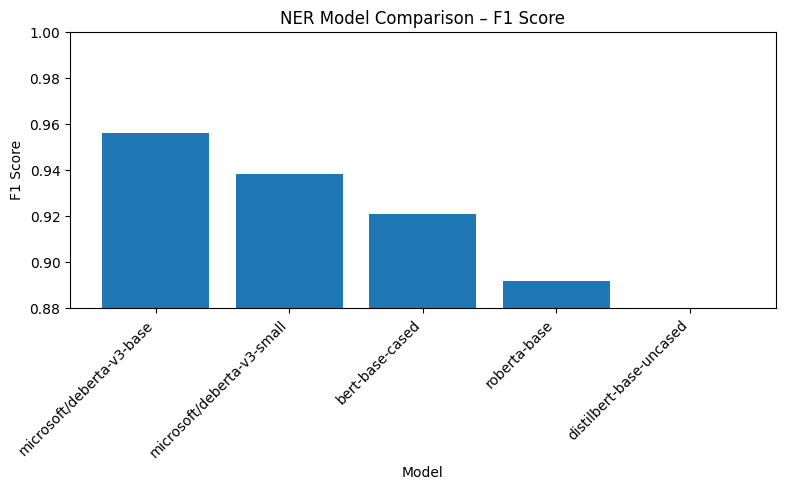

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv("/kaggle/working/model_comparison_results_fixed.csv")

# Sort by F1
df = df.sort_values("f1_score", ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(df["model_name"], df["f1_score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.title("NER Model Comparison – F1 Score")

plt.tight_layout()
plt.savefig("/kaggle/working/f1_comparison.png", dpi=300)
plt.ylim(0.88, 1.0)

plt.show()

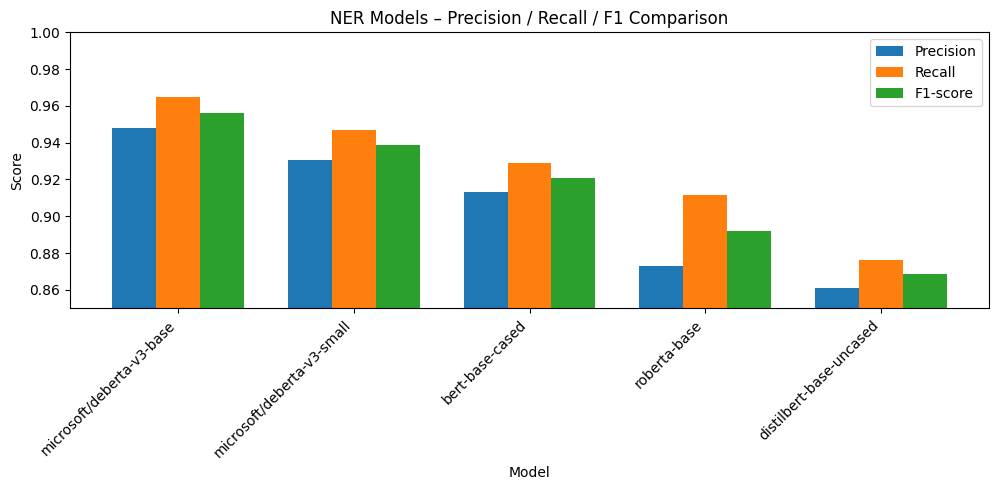

In [26]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ["precision", "recall", "f1_score"]
x = np.arange(len(df["model_name"]))
width = 0.25

plt.figure(figsize=(10, 5))

plt.bar(x - width, df["precision"], width, label="Precision")
plt.bar(x, df["recall"], width, label="Recall")
plt.bar(x + width, df["f1_score"], width, label="F1-score")

plt.xticks(x, df["model_name"], rotation=45, ha="right")
plt.ylabel("Score")
plt.xlabel("Model")
plt.title("NER Models – Precision / Recall / F1 Comparison")
plt.legend()

plt.tight_layout()
plt.savefig("/kaggle/working/metrics_comparison.png", dpi=300)
plt.ylim(0.85, 1.0)

plt.show()


In [27]:
"""Natural Language Generation (NLG) for City Services Chatbot - Updated for Real Knowledge Base

Compatible with nador_knowledge_base_complete.json structure
Includes Weather API integration (OpenWeatherMap)
"""

import json
import torch
from transformers import (
    GPT2Tokenizer,
    GPT2ForSequenceClassification,
    AutoTokenizer,
    AutoModelForTokenClassification
)
from datetime import datetime, timedelta
import re
import requests

In [44]:
#==============================================================================
# CONFIGURATION
#==============================================================================

CONFIG = {
    'intent_model_path': './intent_gpt2/',
    'ner_model_path': './results_microsoft_deberta-v3-base/checkpoint-57/',
    'knowledge_base_path': '/kaggle/input/knowledge-base/nador_knowledge_base_SIMPLIFIED.json',
    'max_length': 128,
    'temperature': 0.7, 
    'top_p': 0.9,
    'max_response_length': 150,

    # Weather (optional)
    'weather_api_key': '0457425c7592793f1f264eebd5874dad',
    'weather_api_url': 'http://api.openweathermap.org/data/2.5/weather',
    'use_weather_api': True 
}

# Entity to intent mapping
INTENT_LABELS = {
    0: 'bus_schedule',
    1: 'waste_collection',
    2: 'weather',
    3: 'admin_procedure',
    4: 'contact_emergency',
    5: 'find_administration'
}

ENTITY_LABELS = [
    'O', 'B-bus_line', 'I-bus_line', 'B-district', 'I-district',
    'B-date', 'I-date', 'B-document_type', 'I-document_type',
    'B-emergency_type', 'I-emergency_type', 'B-office_name', 'I-office_name'
]

label2id = {label: idx for idx, label in enumerate(ENTITY_LABELS)}
id2label = {idx: label for label, idx in label2id.items()}

In [45]:
#==============================================================================
# KNOWLEDGE BASE
#==============================================================================

# Global variable for knowledge base
KNOWLEDGE_BASE = None

def load_knowledge_base(path=None):
    """Load knowledge base from JSON file"""
    global KNOWLEDGE_BASE
    
    if path is None:
        path = CONFIG['knowledge_base_path']
    
    try:
        with open(path, 'r', encoding='utf-8') as f:
            KNOWLEDGE_BASE = json.load(f)
        print(f"✓ Knowledge base loaded from {path}")
        print(f"  Sections: {list(KNOWLEDGE_BASE.keys())}")
        return True
    except FileNotFoundError:
        print(f"❌ Knowledge base not found at {path}")
        print("   Using fallback minimal knowledge base")
        KNOWLEDGE_BASE = create_fallback_kb()
        return False
    except Exception as e:
        print(f"❌ Error loading knowledge base: {e}")
        print("   Using fallback minimal knowledge base")
        KNOWLEDGE_BASE = create_fallback_kb()
        return False

def create_fallback_kb():
    """Create minimal fallback knowledge base"""
    return {
        "transports": {"bus_lines": []},
        "waste_collection": {"districts": []},
        "useful_contacts": {"emergencies": []},
        "administrations": {},
        "administrative_procedures": {"documents": []}
    }

In [46]:
def load_models():
    """Load trained models"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load Intent Model (GPT-2)
    intent_tokenizer = GPT2Tokenizer.from_pretrained(CONFIG['intent_model_path'])
    intent_model = GPT2ForSequenceClassification.from_pretrained(CONFIG['intent_model_path'])
    intent_model.to(device)
    intent_model.eval()
    
    # Load NER Model
    ner_tokenizer = AutoTokenizer.from_pretrained(CONFIG['ner_model_path'])
    ner_model = AutoModelForTokenClassification.from_pretrained(CONFIG['ner_model_path'])
    ner_model.to(device)
    ner_model.eval()
    
    return {
        'intent_tokenizer': intent_tokenizer,
        'intent_model': intent_model,
        'ner_tokenizer': ner_tokenizer,
        'ner_model': ner_model,
        'device': device
    }

In [31]:
def predict_intent(text, models):
    """Predict intent using GPT-2"""
    encoding = models['intent_tokenizer'](
        text,
        max_length=CONFIG['max_length'],
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(models['device'])
    attention_mask = encoding['attention_mask'].to(models['device'])
    
    with torch.no_grad():
        outputs = models['intent_model'](input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=-1).item()
        confidence = probabilities[0][predicted_class].item()
    
    return {
        'intent': INTENT_LABELS[predicted_class],
        'confidence': confidence
    }

In [32]:
def predict_entities(text, models):
    """Extract entities using NER model"""
    encoding = models['ner_tokenizer'](
        text,
        max_length=CONFIG['max_length'],
        padding='max_length',
        truncation=True,
        return_offsets_mapping=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(models['device'])
    attention_mask = encoding['attention_mask'].to(models['device'])
    offset_mapping = encoding['offset_mapping'].squeeze(0).tolist()
    
    with torch.no_grad():
        outputs = models['ner_model'](input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1).squeeze(0)
    
    entities = []
    current_entity = None
    
    for idx, (pred_id, (start, end)) in enumerate(zip(predictions, offset_mapping)):
        if start == 0 and end == 0:
            continue
        
        label = id2label[pred_id.item()]
        
        if label.startswith('B-'):
            if current_entity:
                entities.append(current_entity)
            
            entity_type = label[2:]
            current_entity = {
                'text': text[start:end],
                'label': entity_type,
                'start': start,
                'end': end
            }
        
        elif label.startswith('I-') and current_entity:
            current_entity['end'] = end
            current_entity['text'] = text[current_entity['start']:end]
        
        else:
            if current_entity:
                entities.append(current_entity)
                current_entity = None
    
    if current_entity:
        entities.append(current_entity)
    
    return entities

In [48]:
"""
SIMPLIFIED KNOWLEDGE BASE LOOKUP FUNCTIONS
For use with nador_knowledge_base_SIMPLIFIED.json

This structure is optimized for chatbot exploitation - all lookups are simple dict/list access
"""

#==============================================================================
# KNOWLEDGE BASE LOOKUP FUNCTIONS (SIMPLIFIED VERSION)
#==============================================================================

def get_bus_schedule(bus_line, district=None):
    """Get bus schedule from knowledge base"""
    if not KNOWLEDGE_BASE or 'transports' not in KNOWLEDGE_BASE:
        return None
    
    bus_lines = KNOWLEDGE_BASE['transports'].get('bus_lines', [])
    
    # Find the bus line
    for bus in bus_lines:
        if str(bus.get('bus_line')) == str(bus_line):
            return bus
    
    return None


def get_waste_collection(district):
    """Get waste collection schedule - SIMPLIFIED"""
    if not KNOWLEDGE_BASE or 'waste_collection' not in KNOWLEDGE_BASE:
        return None
    
    # Direct dict lookup!
    districts = KNOWLEDGE_BASE['waste_collection'].get('districts', {})
    district_lower = district.lower()
    
    # Try exact match
    if district_lower in districts:
        return districts[district_lower]
    
    # Try partial match
    for key, data in districts.items():
        if district_lower in key or key in district_lower:
            return data
    
    return None


def get_emergency_contact(emergency_type):
    """Get emergency contact - SIMPLIFIED"""
    if not KNOWLEDGE_BASE or 'emergencies' not in KNOWLEDGE_BASE:
        return None
    
    emergencies = KNOWLEDGE_BASE['emergencies']
    emergency_lower = emergency_type.lower()
    
    # Simple list search
    for emerg in emergencies:
        service_name = emerg.get('service', '').lower()
        if emergency_lower in service_name or service_name in emergency_lower:
            return emerg
    
    return None


def get_office_info(office_name):
    """Get office information - SIMPLIFIED"""
    if not KNOWLEDGE_BASE or 'administrations' not in KNOWLEDGE_BASE:
        return None
    
    admins = KNOWLEDGE_BASE['administrations']
    office_lower = office_name.lower()
    
    # Check prefecture
    if 'prefecture' in office_lower or 'préfecture' in office_lower:
        return admins.get('prefecture')
    
    # Check municipality
    if 'municipality' in office_lower or 'commune' in office_lower or 'municipal' in office_lower:
        return admins.get('municipality')
    
    # Check urban agency
    if 'urban' in office_lower or 'agency' in office_lower:
        return admins.get('urban_agency')
    
    # Check treasury
    if 'treasury' in office_lower or 'trésor' in office_lower:
        return admins.get('treasury')
    
    # Check annexes
    annexes = admins.get('annexes', [])
    for annex in annexes:
        annex_name = annex.get('name', '').lower()
        if office_lower in annex_name or annex_name in office_lower:
            return annex
    
    return None


def get_document_info(document_type):
    """Get document info - SIMPLIFIED (direct dict lookup!)"""
    if not KNOWLEDGE_BASE or 'documents' not in KNOWLEDGE_BASE:
        return None
    
    # Direct dict lookup by keyword!
    documents = KNOWLEDGE_BASE['documents']
    doc_lower = document_type.lower()
    
    # Try exact match
    if doc_lower in documents:
        return documents[doc_lower]
    
    # Try partial match
    for key, doc_data in documents.items():
        if doc_lower in key or key in doc_lower:
            return doc_data
    
    return None

In [34]:
#==============================================================================
# WEATHER API INTEGRATION
#==============================================================================

def get_weather_from_api(district):
    """Fetch real-time weather from OpenWeatherMap API"""
    if not CONFIG['use_weather_api'] or not CONFIG['weather_api_key'] or CONFIG['weather_api_key'] == 'YOUR_API_KEY_HERE':
        return None
    
    try:
        # Construct location query
        location = f"{district}, Nador, Morocco"
        
        params = {
            'q': location,
            'appid': CONFIG['weather_api_key'],
            'units': 'metric',  # Celsius
            'lang': 'en'
        }
        
        response = requests.get(CONFIG['weather_api_url'], params=params, timeout=5)
        
        if response.status_code == 200:
            data = response.json()
            return {
                'temperature': data['main']['temp'],
                'feels_like': data['main']['feels_like'],
                'humidity': data['main']['humidity'],
                'description': data['weather'][0]['description'],
                'wind_speed': data['wind']['speed'],
                'location': data['name']
            }
    except Exception as e:
        print(f"Weather API error: {e}")
    
    return None

In [35]:
#==============================================================================
# HELPER FUNCTIONS
#==============================================================================

def get_current_time():
    """Get current time for context-aware responses"""
    now = datetime.now()
    return {
        'hour': now.hour,
        'minute': now.minute,
        'day': now.strftime('%A'),
        'date': now.strftime('%Y-%m-%d'),
        'is_weekday': now.weekday() < 5,  # Monday = 0, Friday = 4
        'is_saturday': now.weekday() == 5
    }

def get_next_bus_time(schedule, current_time):
    """Find next bus time from schedule"""
    # Determine schedule type
    if current_time['is_weekday'] or current_time['is_saturday']:
        schedule_key = 'monday_to_saturday'
    else:
        schedule_key = 'sunday'
    
    if schedule_key not in schedule:
        # Try other keys
        if 'weekday' in schedule:
            schedule_key = 'weekday'
        elif 'all_days' in schedule:
            schedule_key = 'all_days'
        else:
            return None
    
    day_schedule = schedule[schedule_key]
    
    # Get outbound departures
    departures = day_schedule.get('outbound', {}).get('departures', [])
    if not departures:
        return None
    
    current_hour = current_time['hour']
    current_minute = current_time['minute']
    
    for time_str in departures:
        hour, minute = map(int, time_str.split(':'))
        if hour > current_hour or (hour == current_hour and minute > current_minute):
            return time_str
    
    # If no more buses today, return first bus tomorrow
    return f"{departures[0]} (tomorrow)"

In [47]:
#==============================================================================
# RESPONSE GENERATION FUNCTIONS
#==============================================================================

def generate_admin_procedure_response(entities, intent_info):
    """Generate response for administrative procedure queries"""
    document_type = None
    
    for entity in entities:
        if entity['label'] == 'document_type':
            document_type = entity['text']
    
    if not document_type:
        return "Which document do you need? I can help with birth certificates, passports, building permits, residence certificates, and more. 📄"
    
    doc_info = get_document_info(document_type)
    
    if not doc_info:
        return f"For information about {document_type}, please contact the Urban Municipality of Nador at 0539-60-88-88."
    
    response = f"📄 {doc_info.get('name', document_type)}\\n\\n"
    
    if 'description' in doc_info and doc_info['description']:
        response += f"ℹ️  {doc_info['description']}\\n\\n"
    
    if 'location' in doc_info and doc_info['location']:
        response += f"🏢 Where to apply: {doc_info['location']}\\n"
    
    requirements = doc_info.get('requirements', [])
    if requirements:
        response += f"\\n📋 Required documents:\\n"
        for req in requirements:
            response += f"  • {req}\\n"
    
    if 'processing_time' in doc_info and doc_info['processing_time']:
        response += f"\\n⏱️  Processing time: {doc_info['processing_time']}\\n"
    
    if 'fee' in doc_info and doc_info['fee']:
        response += f"💰 Fee: {doc_info['fee']}\\n"
    
    if 'hours' in doc_info and doc_info['hours']:
        response += f"🕐 Office hours: {doc_info['hours']}\\n"
    
    if 'notes' in doc_info and doc_info['notes']:
        response += f"\\n💡 Note: {doc_info['notes']}"
    
    return response


# Example of how waste collection response should be updated
def generate_waste_collection_response_UPDATED(entities, intent_info):
    """Generate response for waste collection queries - UPDATED"""
    district = None
    
    for entity in entities:
        if entity['label'] == 'district':
            district = entity['text']
    
    if not district:
        return "Which district are you asking about? I can provide waste collection schedules for Nador districts. 🗑️"
    
    collection_info = get_waste_collection(district)
    
    if not collection_info:
        return f"I'm sorry, I don't have waste collection information for {district}. Please contact the municipality at 0539-60-88-88."
    
    current_time = get_current_time()
    current_day = current_time['day']
    
    response = f"🗑️ Waste Collection in {collection_info.get('name', district)}\n\n"
    
    # Collection days
    days = collection_info.get('collection_days', [])
    if days:
        response += f"📅 Collection days: {', '.join(days)}\n"
    
    # Collection time
    time = collection_info.get('collection_time')
    if time:
        response += f"⏰ Collection time: {time}\n"
    
    # Notes
    notes = collection_info.get('notes')
    if notes:
        response += f"\n💡 {notes}\n"
    
    # Check if today is collection day
    if current_day in days:
        response += f"\n⚠️  Today is a collection day! Please put your bins out before {time if time else 'the scheduled time'}."
    else:
        # Find next collection day
        days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        current_day_idx = days_order.index(current_day)
        
        next_collection = None
        days_until = 7
        
        for i in range(1, 8):
            check_day = days_order[(current_day_idx + i) % 7]
            if check_day in days:
                next_collection = check_day
                days_until = i
                break
        
        if next_collection:
            if days_until == 1:
                response += f"\n📍 Next collection: Tomorrow ({next_collection})"
            else:
                response += f"\n📍 Next collection: {next_collection} (in {days_until} days)"
    
    return response

def generate_bus_schedule_response(entities, intent_info):
    """Generate response for bus schedule queries"""
    bus_line = None
    district = None
    
    for entity in entities:
        if entity['label'] == 'bus_line':
            bus_line = entity['text']
        elif entity['label'] == 'district':
            district = entity['text']
    
    if not bus_line:
        return "I'd be happy to help with bus schedules! Which bus line are you interested in? 🚌"
    
    schedule = get_bus_schedule(bus_line, district)
    
    if not schedule:
        return f"I'm sorry, I don't have schedule information for bus {bus_line}. Please contact the bus station for more information."
    
    current_time = get_current_time()
    
    response = f"🚌 Bus {bus_line} - {schedule.get('name', 'Bus Line')}\n\n"
    
    # Route information
    route = schedule.get('route', [])
    if route:
        response += f"📍 Route: {' → '.join(route[:5])}"  # Show first 5 stops
        if len(route) > 5:
            response += f" ... ({len(route)} stops total)"
        response += "\n\n"
    
    # Schedule information
    sched = schedule.get('schedule', {})
    if current_time['is_weekday'] or current_time['is_saturday']:
        schedule_key = 'monday_to_saturday'
        day_name = 'Monday-Saturday'
    else:
        schedule_key = 'sunday'
        day_name = 'Sunday'
    
    if schedule_key in sched:
        day_sched = sched[schedule_key]
        
        # Next bus
        next_time = get_next_bus_time(sched, current_time)
        if next_time:
            response += f"⏰ Next bus: {next_time}\n\n"
        
        # First and last departures
        first_out = day_sched.get('first_departure_outbound')
        last_out = day_sched.get('last_departure_outbound')
        
        if first_out and last_out:
            response += f"🕐 {day_name} Schedule:\n"
            response += f"  First departure: {first_out}\n"
            response += f"  Last departure: {last_out}\n"
        
        # Frequency
        freq = schedule.get('frequency')
        if freq:
            response += f"\n🔄 Frequency: {freq}"
    
    # Fare information
    if 'fare' in schedule:
        response += f"\n\n💰 Fare: {schedule['fare']} MAD"
    
    return response


def generate_emergency_contact_response(entities, intent_info):
    """Generate response for emergency contact queries"""
    emergency_type = None
    
    for entity in entities:
        if entity['label'] == 'emergency_type':
            emergency_type = entity['text']
    
    if not emergency_type:
        return "Which emergency service do you need? I can provide numbers for Police, Fire Department, Medical Emergency (SAMU), Royal Gendarmerie, Civil Protection, and ONEE (water/electricity). 🚨"
    
    contact_info = get_emergency_contact(emergency_type)
    
    if not contact_info:
        return f"I'm sorry, I don't have contact information for {emergency_type}. For general emergencies, dial 19 (Police) or 15 (Fire)."
    
    response = f"🚨 {contact_info.get('service', emergency_type)} Emergency Contact\n\n"
    response += f"📞 Number: {contact_info.get('number', 'N/A')}\n"
    
    response += "\n⚠️ This is an emergency number. Please call only in case of emergency."
    
    return response

def generate_find_administration_response(entities, intent_info):
    """Generate response for finding administration offices"""
    office_name = None
    
    for entity in entities:
        if entity['label'] == 'office_name':
            office_name = entity['text']
    
    if not office_name:
        return "Which office are you looking for? I can help you find the Prefecture, Municipality, Urban Agency, Treasury, or Administrative Annexes. 🏛️"
    
    office_info = get_office_info(office_name)
    
    if not office_info:
        return f"I'm sorry, I don't have information about {office_name}. Please call the municipality at 0539-60-88-88 for assistance."
    
    response = f"🏛️ {office_info.get('name', office_name)}\n\n"
    response += f"📍 Address: {office_info.get('address', 'N/A')}\n"
    response += f"📞 Phone: {office_info.get('phone', 'N/A')}\n"
    
    if 'email' in office_info:
        response += f"📧 Email: {office_info['email']}\n"
    
    response += f"🕐 Hours: {office_info.get('hours', 'N/A')}\n"
    
    # Services
    services = office_info.get('services', [])
    if services:
        response += f"\n📋 Available services:\n"
        for service in services:
            response += f"  • {service}\n"
    
    return response

def generate_weather_response(entities, intent_info):
    """Generate response for weather queries"""
    district = None
    date = None
    
    for entity in entities:
        if entity['label'] == 'district':
            district = entity['text']
        elif entity['label'] == 'date':
            date = entity['text']
    
    # Try to get weather from API
    if district and CONFIG['use_weather_api']:
        weather_data = get_weather_from_api(district)
        
        if weather_data:
            response = f"🌤️ Current Weather in {weather_data['location']}\n\n"
            response += f"🌡️ Temperature: {weather_data['temperature']:.1f}°C (feels like {weather_data['feels_like']:.1f}°C)\n"
            response += f"☁️ Conditions: {weather_data['description'].capitalize()}\n"
            response += f"💧 Humidity: {weather_data['humidity']}%\n"
            response += f"💨 Wind: {weather_data['wind_speed']} m/s\n"
            
            if date and 'tomorrow' in date.lower():
                response += f"\n💡 For tomorrow's forecast, please check www.weather.ma or weather apps."
            
            return response
    
    # Fallback response
    response = f"🌤️ Weather Information\n\n"
    
    location = district if district else "the Nador region"
    response += f"For current weather in {location}, please:\n\n"
    response += "🌐 Visit: www.weather.ma (Morocco Meteorology)\n"
    response += "📞 Call: 0537-37-37-73 (National Meteorological Service)\n\n"
    response += "💡 You can also check:\n"
    response += "  • Weather apps on your smartphone\n"
    response += "  • www.accuweather.com\n"
    response += "  • www.weather.com"
    
    return response

In [37]:
#==============================================================================
# MAIN CHATBOT PIPELINE
#==============================================================================

def generate_response(text, models):
    """Main chatbot pipeline"""
    # Step 1: Predict intent
    intent_info = predict_intent(text, models)
    
    # Step 2: Extract entities
    entities = predict_entities(text, models)
    
    # Step 3: Generate response
    intent = intent_info['intent']
    
    response_generators = {
        'bus_schedule': generate_bus_schedule_response,
        'waste_collection': generate_waste_collection_response,
        'contact_emergency': generate_emergency_contact_response,
        'admin_procedure': generate_admin_procedure_response,
        'find_administration': generate_find_administration_response,
        'weather': generate_weather_response
    }
    
    if intent in response_generators:
        response = response_generators[intent](entities, intent_info)
    else:
        response = "I'm not sure how to help with that. Could you rephrase your question? 🤔"
    
    return {
        'user_query': text,
        'intent': intent_info,
        'entities': entities,
        'response': response
    }

In [38]:
#==============================================================================
# INTERACTIVE CHATBOT
#==============================================================================

def run_chatbot():
    """Interactive chatbot interface"""
    print("="*80)
    print("CITY SERVICES CHATBOT - Interactive Mode")
    print("="*80)
    print("\nLoading knowledge base...")
    load_knowledge_base()
    
    print("\nLoading models...")
    models = load_models()
    
    print("✓ All systems ready!")
    print("\nYou can ask me about:")
    print("  • Bus schedules (e.g., 'When does bus 15 arrive?')")
    print("  • Waste collection (e.g., 'When is garbage day in Arouit?')")
    print("  • Emergency contacts (e.g., 'What is the Fire Department number?')")
    print("  • Document applications (e.g., 'How do I get a birth certificate?')")
    print("  • Office locations (e.g., 'Where is the Prefecture?')")
    print("  • Weather (e.g., 'What's the weather in Nador?')")
    print("\nType 'quit' to exit")
    print("="*80)
    
    while True:
        user_input = input("\n👤 You: ").strip()
        
        if user_input.lower() in ['quit', 'exit', 'bye']:
            print("\n👋 Goodbye! Have a great day!")
            break
        
        if not user_input:
            continue
        
        # Generate response
        result = generate_response(user_input, models)
        
        # Display response
        print(f"\n🤖 Assistant:\n{result['response']}")
        
        # Debug info (optional)
        if False:  # Set to True for debugging
            print(f"\n[Debug] Intent: {result['intent']['intent']} "
                  f"(confidence: {result['intent']['confidence']:.2f})")
            if result['entities']:
                print(f"[Debug] Entities: {[(e['label'], e['text']) for e in result['entities']]}")

In [ ]:
#==============================================================================
# TESTING
#==============================================================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("TESTING NLG SYSTEM WITH REAL KNOWLEDGE BASE")
    print("="*80)
    
    # Load knowledge base
    print("\nLoading knowledge base...")
    kb_loaded = load_knowledge_base()
    
    if kb_loaded:
        print(f"✓ Knowledge base loaded successfully!")
        print(f"  Bus lines: {len(KNOWLEDGE_BASE['transports']['bus_lines'])}")
        print(f"  Districts: {len(KNOWLEDGE_BASE.get('districts', []))}")
    
    # Load models
    print("\nLoading models...")
    models = load_models()
    print("✓ Models loaded!\n")
    
    # Test queries
    test_queries = [
        "When does bus 1 arrive?",
        "What time is waste collected in Arouit?",
        "What is the Fire Department emergency number?",
        "How do I get a birth certificate?",
        "Where is the Prefecture of Nador-Driouch?",
        "What's the weather in Nador?"
    ]
    
    for query in test_queries:
        print("="*80)
        print(f"Query: {query}")
        print("="*80)
        
        result = generate_response(query, models)
        
        print(f"\n{result['response']}\n")
    
    # Start interactive mode
    print("\n" + "="*80)
    print("Starting Interactive Mode...")
    print("="*80)
    
    run_chatbot()


TESTING NLG SYSTEM WITH REAL KNOWLEDGE BASE

Loading knowledge base...
✓ Knowledge base loaded from /kaggle/input/knowledge-base/nador_knowledge_base_SIMPLIFIED.json
  Sections: ['metadata', 'transports', 'waste_collection', 'emergencies', 'administrations', 'documents']
✓ Knowledge base loaded successfully!
  Bus lines: 13
  Districts: 0

Loading models...
✓ Models loaded!

Query: When does bus 1 arrive?

I'm sorry, I don't have schedule information for bus  1. Please contact the bus station for more information.

Query: What time is waste collected in Arouit?

🗑️ Waste Collection in Arouit

📅 Collection days: Monday, Wednesday, Friday
⏰ Collection time: 08:00 - 11:00

📍 Next collection: Monday (in 2 days)

Query: What is the Fire Department emergency number?

I'm sorry, I don't have contact information for  emergency number. For general emergencies, dial 19 (Police) or 15 (Fire).

Query: How do I get a birth certificate?

📄 Birth Certificate\n\nℹ️  Birth certificate extract\n\n🏢 Whe


👤 You:  Process for marriage certificate



🤖 Assistant:
📄 Marriage Certificate\n\nℹ️  Marriage certificate extract\n\n🏢 Where to apply: Civil Status Office where marriage was registered\n\n📋 Required documents:\n  • CIN of both spouses\n  • Marriage certificate number (if known)\n\n⏱️  Processing time: Immediate to 2 days\n💰 Fee: 20 MAD\n🕐 Office hours: 08:30 - 16:00\n



👤 You:  Is tomorrow garbage day Zaio?



🤖 Assistant:
🗑️ Waste Collection in Zaio

📅 Collection days: Tuesday, Thursday, Saturday
⏰ Collection time: 08:00 - 11:00

⚠️ Today is a collection day! Please put your bins out before 08:00 - 11:00.



👤 You:  When does bus 15 arrive?



🤖 Assistant:
I'm sorry, I don't have schedule information for bus  15. Please contact the bus station for more information.



👤 You:  When does bus15 arrive



🤖 Assistant:
🚌 Bus 15 - Zegangan - Nador

📍 Route: Zegangan → Hay Zegangan → Route de Selouane → Boulevard Youssef Ben Tachfine → Nador Center

⏰ Next bus: 07:00

🕐 Monday-Saturday Schedule:
  First departure: 07:00
  Last departure: 20:00

🔄 Frequency: {'morning_07_11': '10 minutes', 'midday_11_20': '7 minutes', 'evening_20_2130': '10 minutes'}

💰 Fare: 4.00 MAD MAD



👤 You:  When does bus21 arrive



🤖 Assistant:
🚌 Bus 21 - Selouane - Nador - Faculty

📍 Route: Selouane → Douar Laaouama → Route de Selouane → University Campus → Multidisciplinary Faculty ... (8 stops total)

⏰ Next bus: 07:00

🕐 Monday-Saturday Schedule:
  First departure: 07:00
  Last departure: 20:30

🔄 Frequency: {'morning_07_11': '15 minutes', 'midday_11_20': '8 minutes', 'evening_20_2130': '15 minutes'}

💰 Fare: 5.00 MAD MAD



👤 You:  What's the weather in Nador?



🤖 Assistant:
🌤️ Weather Information

For current weather in  Nador, please:

🌐 Visit: www.weather.ma (Morocco Meteorology)
📞 Call: 0537-37-37-73 (National Meteorological Service)

💡 You can also check:
  • Weather apps on your smartphone
  • www.accuweather.com
  • www.weather.com



👤 You:  hello



🤖 Assistant:
Which emergency service do you need? I can provide numbers for Police, Fire Department, Medical Emergency (SAMU), Royal Gendarmerie, Civil Protection, and ONEE (water/electricity). 🚨



👤 You:  How do I reach Royal Gendarmerie urgently?



🤖 Assistant:
🚨 Royal Gendarmerie Emergency Contact

📞 Number: 177

⚠️ This is an emergency number. Please call only in case of emergency.



👤 You:  I need Urban Municipality of Nador address



🤖 Assistant:
🏛️ Urban Municipality of Nador

📍 Address: Place 3 Mars
📞 Phone: 0539-60-88-88
📧 Email: contact@nador.ma
🕐 Hours: 08:30 - 16:00

📋 Available services:
  • Civil status
  • Urban planning
  • Local taxes

